Is this customer likely to return things in general?
Predict whether a customer is a returner

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [ ]:
df_2010 = pd.read_excel("online_retail_II.xlsx", sheet_name="Year 2010-2011")
df_2009 = pd.read_excel("online_retail_II.xlsx", sheet_name="Year 2009-2010")

print(df_2010.shape, df_2009.shape)

In [ ]:
df = pd.concat([df_2009, df_2010], ignore_index=True)
print(df.shape)
df.info()

In [ ]:
# Drop rows with missing CustomerID
df = df.dropna(subset=["Customer ID"])

# Convert data types
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['Customer ID'] = df['Customer ID'].astype(str)

In [ ]:
df.describe()

In [ ]:
df.isna().sum()

In [ ]:
df['Invoice'] = df['Invoice'].astype(str)

#separate purchases and returns (returns have invoice with 'C' prefix)
purchases = df[~df['Invoice'].str.startswith('C')].copy()
returns = df[df['Invoice'].str.startswith('C')].copy() #no missing customer ID or Invoice 

In [ ]:
df.InvoiceDate.min(), df.InvoiceDate.max()

In [ ]:
returns.iloc[900:901]

In [ ]:
purchases[(purchases['Customer ID'] == "17696.0") & (purchases['StockCode'] == 20931)]

For one return, the stockcode and customer ID could match with multiple purchases. Match stockcode, customerID, and invoicedate of return should be after invoicedate of purchase

In [ ]:
# Add a return flag column
purchases['IsReturn'] = 0

# Sort for easier lookup
purchases.sort_values(by='InvoiceDate', inplace=True)
returns.sort_values(by='InvoiceDate', inplace=True)

# Loop through each return and flag the latest matching purchase before it
for _, ret_row in returns.iterrows():
    cust_id = ret_row['Customer ID']
    stock = ret_row['StockCode']
    ret_date = ret_row['InvoiceDate']
    
    # Find purchases of the same item by the same customer BEFORE the return
    eligible_purchases = purchases[
        (purchases['Customer ID'] == cust_id) &
        (purchases['StockCode'] == stock) &
        (purchases['InvoiceDate'] < ret_date) &
        (purchases['IsReturn'] == 0)  # avoid double-flagging
    ]
    
    if not eligible_purchases.empty:
        # Flag the latest eligible purchase before this return
        idx_to_flag = eligible_purchases.index[-1]
        purchases.at[idx_to_flag, 'IsReturn'] = 1

In [ ]:
def bucket_hour(hour):
    if 0 <= hour <= 5:
        return 'Early Morning'
    elif 6 <= hour <= 11:
        return 'Morning'
    elif 12 <= hour <= 17:
        return 'Afternoon'
    elif 18 <= hour <= 21:
        return 'Evening'
    else:
        return 'Late Night'

In [ ]:
# Create the hour column first
purchases['InvoiceHour'] = purchases['InvoiceDate'].dt.hour
# Apply bucketing
purchases['TimeOfDay'] = purchases['InvoiceHour'].apply(bucket_hour)
purchases = pd.get_dummies(purchases, columns=['TimeOfDay'], prefix='Time') #no early morning or late night exists

time_cols = [col for col in purchases.columns if col.startswith('Time_')]
purchases[time_cols] = purchases[time_cols].astype(int)

In [ ]:
purchases['InvoiceDayOfWeek'] = purchases['InvoiceDate'].dt.dayofweek  # 0 = Monday
purchases['InvoiceMonth'] = purchases['InvoiceDate'].dt.month
purchases['IsWeekend'] = purchases['InvoiceDayOfWeek'].isin([5,6]).astype(int)

In [ ]:
purchases.info()

In [ ]:
free_price_rows = purchases[purchases['Price'] == 0].Price.count() #free products in orders 
print(free_price_rows) #71 rows 

#remove rows where UnitPrice <= 0 because they don’t represent real purchasable items

# Filter out rows that aren't valid purchases
valid_rows = purchases[purchases['Price'] > 0]

In [ ]:
valid_rows.to_csv('valid_purchases_transaction_level.csv', index=False)

Checkpoint

In [4]:
valid_rows = pd.read_csv('valid_purchases_transaction_level.csv')

In [5]:
# Aggregate time-of-day behavior (mean: % of transactions in each time bucket)
time_cols = ['Time_Morning', 'Time_Afternoon', 'Time_Evening']
time_features = valid_rows.groupby('Customer ID')[time_cols].mean().reset_index()
#time_features.head()

# Aggregate invoice day-of-week
dow_features = pd.get_dummies(valid_rows[['Customer ID', 'InvoiceDayOfWeek']], columns=['InvoiceDayOfWeek'], prefix='Day').astype(int)
dow_features = dow_features.groupby('Customer ID').mean().reset_index()
#dow_features.head()

In [6]:
# Group by StockCode (product ID) - product features
product_counts = valid_rows.groupby(['Customer ID', 'StockCode']).size().reset_index(name='count')
diversity = product_counts.groupby('Customer ID')['StockCode'].nunique().reset_index(name='UniqueProducts')
diversity.head()

,Customer ID,UniqueProducts
0,12346.0,27
1,12347.0,126
2,12348.0,25
3,12349.0,138
4,12350.0,17


In [7]:
time_dow= time_features.merge(dow_features, on='Customer ID', how='outer')
df1 = time_dow.merge(diversity, on='Customer ID', how='outer')
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5878 entries, 0 to 5877
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Customer ID     5878 non-null   float64
 1   Time_Morning    5878 non-null   float64
 2   Time_Afternoon  5878 non-null   float64
 3   Time_Evening    5878 non-null   float64
 4   Day_0           5878 non-null   float64
 5   Day_1           5878 non-null   float64
 6   Day_2           5878 non-null   float64
 7   Day_3           5878 non-null   float64
 8   Day_4           5878 non-null   float64
 9   Day_5           5878 non-null   float64
 10  Day_6           5878 non-null   float64
 11  UniqueProducts  5878 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 551.2 KB


In [8]:
valid_rows['InvoiceDate'] = pd.to_datetime(valid_rows['InvoiceDate'])

# Create total spend per row
valid_rows['TotalLineValue'] = valid_rows['Quantity'] * valid_rows['Price']

# Base customer-level aggregations
customer_features = valid_rows.groupby('Customer ID').agg(
CustomerOrdersPlaced=('Invoice', 'nunique'),
CustomerTotalItems=('Quantity', 'sum'),
CustomerTotalSpend=('TotalLineValue', 'sum'),
CustomerFirstPurchase=('InvoiceDate', 'min'),
CustomerLastPurchase=('InvoiceDate', 'max'),
CustomerDaysActive=('InvoiceDate', lambda x: x.dt.date.nunique()),
CustomerCountry=('Country', 'first')
).reset_index()

# Derived metrics
customer_features['CustomerAvgBasketSize'] = customer_features['CustomerTotalItems'] / customer_features['CustomerOrdersPlaced']
customer_features['CustomerAvgSpend'] = customer_features['CustomerTotalSpend'] / customer_features['CustomerOrdersPlaced']
customer_features['CustomerLoyaltySpan'] = (customer_features['CustomerLastPurchase'] - customer_features['CustomerFirstPurchase']).dt.days

# Drop unnecessary date columns
customer_features.drop(['CustomerFirstPurchase', 'CustomerLastPurchase'], axis=1, inplace=True)

In [9]:
customer_features.CustomerDaysActive.describe()

count    5878.000000
mean        5.632358
std         9.999783
min         1.000000
25%         1.000000
50%         3.000000
75%         6.000000
max       255.000000
Name: CustomerDaysActive, dtype: float64

<Axes: xlabel='CustomerActivityLevel'>

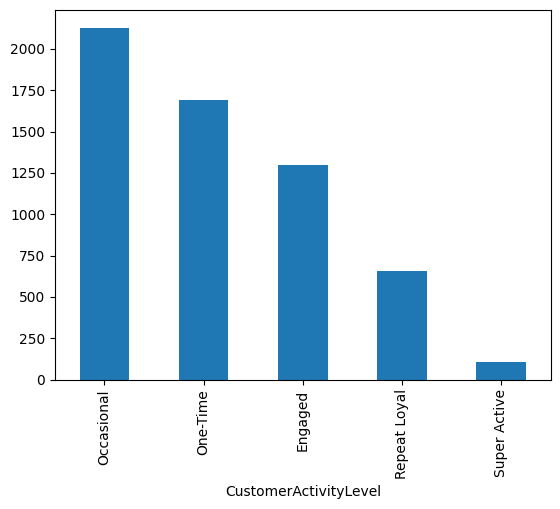

In [10]:
def bucket_days_active(days):
    if days == 1:
        return 'One-Time'
    elif 2 <= days <= 4:
        return 'Occasional'
    elif 5 <= days <= 10:
        return 'Engaged'
    elif 11 <= days <= 30:
        return 'Repeat Loyal'
    else:
        return 'Super Active'

customer_features['CustomerActivityLevel'] = customer_features['CustomerDaysActive'].apply(bucket_days_active)
customer_features['CustomerActivityLevel'].value_counts().plot(kind='bar')

In [11]:
customer_features = pd.get_dummies(customer_features, columns=['CustomerActivityLevel'], prefix='Active')
customer_features_cols = [col for col in customer_features.columns if col.startswith('Active_')]
customer_features[customer_features_cols] = customer_features[customer_features_cols].astype(int)

In [12]:
# Merge back into main df
df2 = df1.merge(customer_features, on='Customer ID', how='outer')

In [13]:
# Add return behavior from full data (IsReturn = 1 rows included here)
return_stats = valid_rows.groupby('Customer ID')['IsReturn'].agg(
CustomerNumOfReturns='sum',
CustomerReturnRate='mean'
).reset_index()

# Merge return stats into main features
df3 = df2.merge(return_stats, on='Customer ID', how='outer')

In [14]:
# One-hot encode customer country
customer_features_country = pd.get_dummies(df3, columns=['CustomerCountry'], prefix='Country')
customer_country_cols = [col for col in customer_features_country.columns if col.startswith('Country_')]
df3[customer_country_cols] = customer_features_country[customer_country_cols].astype(int)

In [15]:
df3['CustomerNumOfReturns'].describe()

count    5878.000000
mean        2.736645
std        10.204280
min         0.000000
25%         0.000000
50%         0.000000
75%         2.000000
max       342.000000
Name: CustomerNumOfReturns, dtype: float64

In [16]:
# Return rate
df3['CustomerReturnRate'].describe()

count    5878.000000
mean        0.027694
std         0.092292
min         0.000000
25%         0.000000
50%         0.000000
75%         0.021254
max         1.000000
Name: CustomerReturnRate, dtype: float64

Pick 3% Return Rate as the threshold to define returners

In [17]:
df3['Returner'] = ((df3['CustomerReturnRate'] >= 0.03)).astype(int)
df3['Returner'].value_counts(normalize=True)

Returner
0    0.799251
1    0.200749
Name: proportion, dtype: float64

In [26]:
# Define target variable
y = df3['Returner']
# Drop columns that should not be used as features
X = df3.drop(columns=['Customer ID','Returner']) 

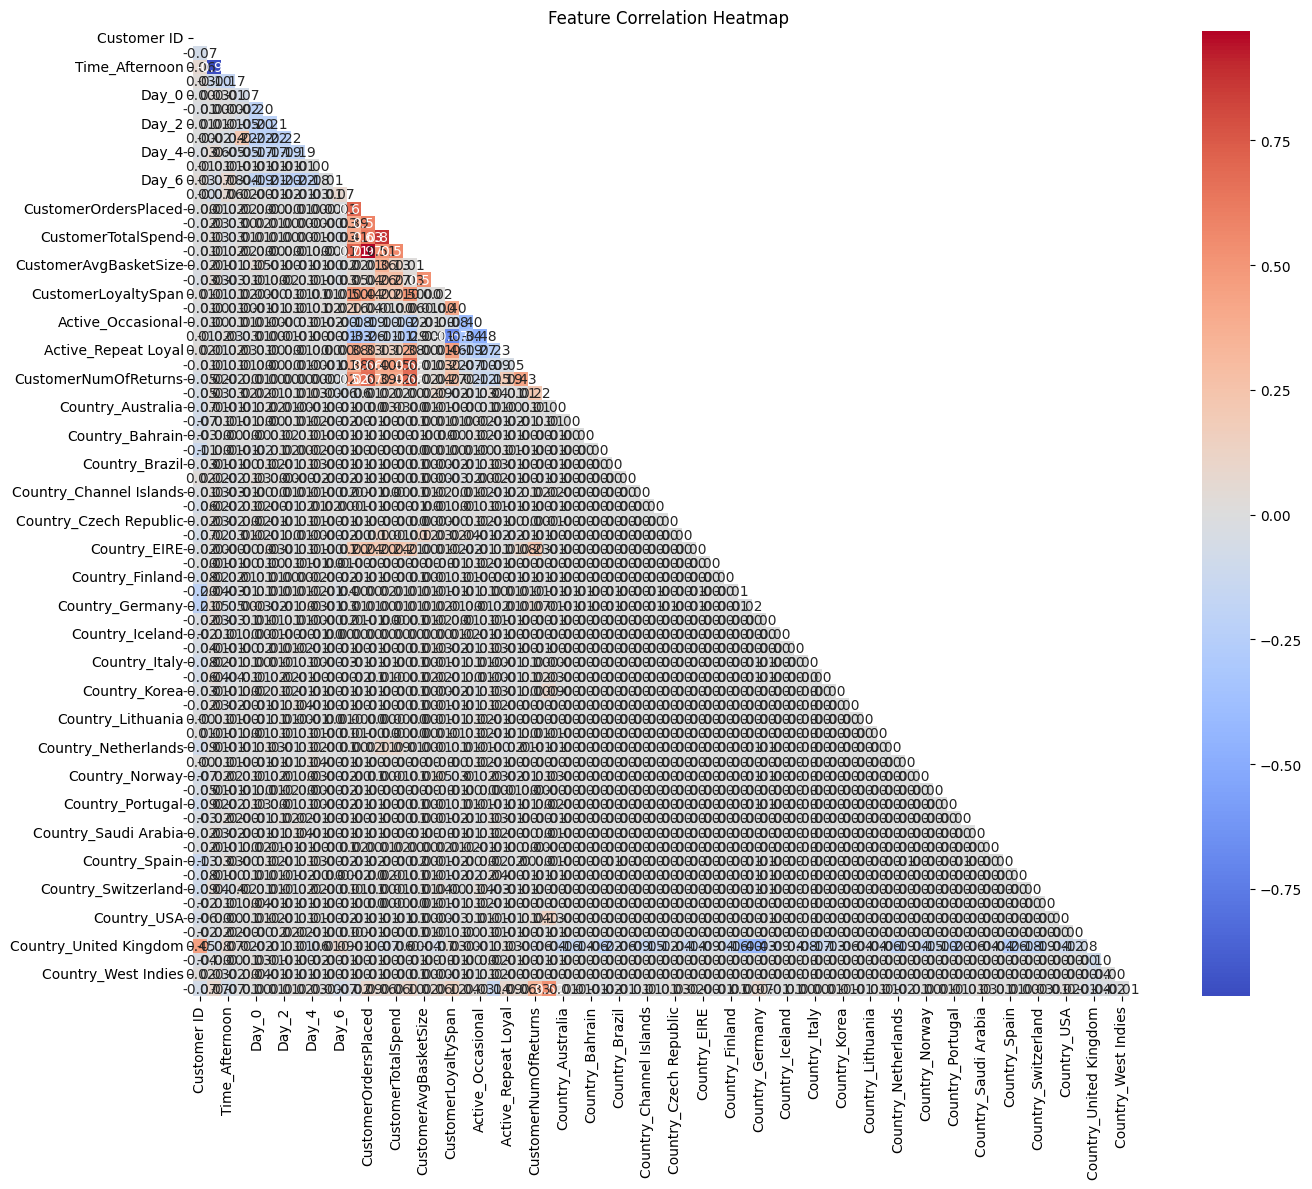

In [ ]:
corr = df3.corr(numeric_only=True)

"""
# Plot heatmap
plt.figure(figsize=(14, 12))
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.tight_layout()
plt.show()"
"""

In [30]:
high_corr = corr[(corr > 0.8) & (corr < 1.0)]
high_corr_only = high_corr.dropna(how='all').dropna(axis=1, how='all')
high_corr_only

,CustomerOrdersPlaced,CustomerTotalItems,CustomerTotalSpend,CustomerDaysActive
CustomerOrdersPlaced,NaN,NaN,NaN,0.968489
CustomerTotalItems,NaN,NaN,0.873558,NaN
CustomerTotalSpend,NaN,0.873558,NaN,NaN
CustomerDaysActive,0.968489,NaN,NaN,NaN


In [31]:
high_corr_only.columns

Index(['CustomerOrdersPlaced', 'CustomerTotalItems', 'CustomerTotalSpend',
       'CustomerDaysActive'],
      dtype='object')

In [34]:
target_corr = corr['Returner'].sort_values(ascending=False)
for col in high_corr_only.columns:
    print(col)
    print(target_corr[col])
    print("\n")

CustomerOrdersPlaced
0.08928204760487948


CustomerTotalItems
0.06126724941771337


CustomerTotalSpend
0.06037474136664972


CustomerDaysActive
0.09547945260850954




In [35]:
df3[df3['Returner'] == 1].shape[0]

1180

In [36]:
df3[df3['Returner'] == 0].shape[0]

4698

In [ ]:
df3[df3['Returner'] == 1].shape[0] / df3[df3['Returner'] == 0].shape[0] #25% of minority class

0.2511707109408259

In [39]:
df3.to_csv('online_retail_cleaned_customerlevel.csv', index=False)